In [41]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, './s2spy')
import s2spy
from s2spy import RGDR
import utils, plotting, verification
path_obs_data = '~/data/volume_2/observational/'

In [2]:
target = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'chrips_tp_1981-2021_africa_aggregated_intervals.nc'))
target

<xarray.DataArray 'precip' (anchor_year: 41, target_period: 10, latitude: 79,
                            longitude: 72)>
[2332080 values with dtype=float32]
Coordinates:
  * anchor_year    (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
  * target_period  (target_period) int64 0 1 2 3 4 5 6 7 8 9
  * longitude      (longitude) float64 33.12 33.38 33.62 ... 50.38 50.62 50.88
  * latitude       (latitude) float64 -4.625 -4.375 -4.125 ... 14.38 14.62 14.88
    target         bool ...

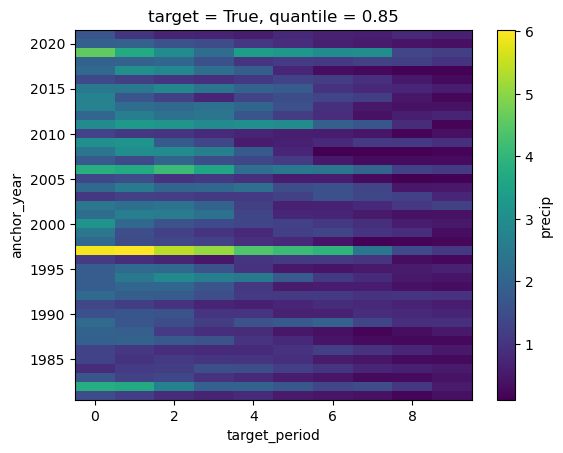

In [76]:
hoa_mask = xr.open_dataarray(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target.where(hoa_mask).mean(dim=('latitude', 'longitude'))
target_timeseries.plot()

## Get prediciton 4-week intervals, needed to align precursor field at specific lead-time:

In [4]:
dfs = pd.read_hdf(os.path.join(path_obs_data, 'aggregation_timestamps.h5')).sort_index()
df = dfs[['aggregation_start_inclusive', 'aggregation_end_inclusive']].copy()
# get 4-week periods that fall within the October, November, December months
sel_months = [10, 11, 12]
mon_start_mask = [True if m in sel_months else False for m in df.set_index('aggregation_start_inclusive').index.month]
mon_end_mask = [True if m in sel_months else False for m in df.set_index('aggregation_end_inclusive').index.month]
mon_mask = np.logical_and(mon_start_mask, mon_end_mask)
df_sub = dfs[mon_mask][dfs[mon_mask].index.year==dfs[mon_mask].index.year[0]]
# extract initialization data -1 day (because we need historic data)
anchor_dates = [(d.month, d.day) for d in df_sub.index - pd.Timedelta('1d')] 

## Loop over different dimensionality reduction methods

In [5]:
def pipeline_dimred(X_train, y, dimred_list = [RGDR()]):
    
    if type(X_train) is not list:
        X_train = [X_train]
    assert len(X_train) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    
    for i, X_ in enumerate(X_train):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            dimred.fit(X_, y)
        else: # assuming EOF-like dimred from eofs package
            model = dimred(X_, dim=['anchor_year'], weights='coslat', n_modes=2)
            model.solve()
            dimred_list[i] = model # replace unitialized EOF-like class with fitted instance
            
    return dimred_list


## Develop function to merge all reduced features

In [6]:
def merge_features(X, dimred_list = [RGDR()]):
    
    if type(X) is not list:
        X = [X]
    assert len(X) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    features_list = []
    for i, X_ in enumerate(X):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            features = dimred.transform(X_)
            # give common dimension name to stack features
            features = features.rename({'cluster_labels':'feature'})
            # transform dimensions into shape (samples, features)
            features = features.transpose("anchor_year", "feature")            
        else: # assuming EOF-like dimred from eofs package
            features = dimred.project_onto_eofs(X_)
            features = features.rename({'mode':'feature'})

        # clear features
        empty_coords = [k for k in features.coords.keys() if k not in ['anchor_year', 'feature']]
        if len(empty_coords) != 0:
            for c in empty_coords:
                    features = features.drop(c)
        features_list.append(features)
    return xr.concat(features_list, dim='feature')



## Set up experiment:

In [38]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

# # define X
# lags = np.arange(1,3)
# X = [sst_resampled['sst'].sel(i_interval=lags), 
#      t2m_resampled['t2m'].sel(i_interval=lags),
#      t2m_resampled['t2m'].sel(i_interval=lags).mean(dim='i_interval')] 

# X = [sst_resampled['sst'].sel(i_interval=lags)]

# # Gradient Boosting Regressor
# fixed_params = {"min_samples_split": 5,
#                 "learning_rate": 0.005,
#                }
# param_grid = {"n_estimators": [300],
#               "max_depth": [1,3,5, 10]
#              }

# regressor = ensemble.GradientBoostingClassifier(**fixed_params)
                  
# scoring_metric = 'neg_brier_score'
# regressor = GridSearchCV(regressor,
#                          param_grid=param_grid,
#                          scoring=scoring_metric, 
#                          cv=KFold(n_splits=5), refit=True,
#                          return_train_score=True,
#                          n_jobs=6)

regressor = LogisticRegressionCV()

# outer cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
import s2spy.traintest

n_splits = 20
kfold = KFold(n_splits=n_splits)
cv = s2spy.traintest.TrainTestSplit(kfold)

def event_timeseries(y):
    '''
    transforms y into terciles based on quantiles of entire dataset
    '''   
    y_events = y.copy() ; y_events.values[:] = 0
    y_events[y < float(y.quantile(.33))] = 1
    # y_events[y > float(y.quantile(.66))] = 1
    return y_events 
    

In [63]:
from sklearn.linear_model import RidgeCV
n_splits = 20
kfold = KFold(n_splits=n_splits)
cv = s2spy.traintest.TrainTestSplit(kfold)
from sklearn.metrics import roc_auc_score

# regressor = LogisticRegressionCV(Cs=30)
regressor = RidgeCV(alphas=np.linspace(0.001, 30, 50))

i = 0 ; 
anchor_date = anchor_dates[i]

# Prediction Target Period
y = target_timeseries.sel(target_period=i)
# y = event_timeseries(y)
date_s = df_sub.iloc[i]['aggregation_start_inclusive'] ; date_e = df_sub.iloc[i]['aggregation_end_inclusive']
print(f'{i}\nPrediction released on: {anchor_date[0]}-{anchor_date[1]+1}')
print(f'Target period: {date_s.month}-{date_s.day} to {date_e.month}-{date_e.day}')

# create Advent (backwards) calendar, aligned right on anchor_date
cal = s2spy.time.AdventCalendar(anchor=anchor_date, freq='30d')
cal = cal.map_years(1981, 2021)

# Get and resample precursor fields
sst = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc'))
sst_resampled = s2spy.time.resample(cal, sst)

z200 = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'era5_z_200hpa_1959-2021_1_12_daily_2.0deg.nc'))
z200_resampled = s2spy.time.resample(cal, z200)

lags = np.arange(0,2)
X = [sst_resampled['sst'].sel(i_interval=lags)]

test_pred = []
train_test = {}
for i, (x_train, x_test, y_train, y_test) in enumerate(cv.split(*X, y=y)):

    rgdr = RGDR()
    features_train = rgdr.fit_transform(x_train, y_train)
    regressor.fit(features_train, y_train)
    
    features_test = rgdr.transform(x_test)
    
    # y_pred_train = regressor.predict_proba(features_train)[:,1]
    # y_pred = regressor.predict_proba(features_test)[:,1]
    
    y_pred_train = regressor.predict(features_train)
    y_pred = regressor.predict(features_test)
    
    test_pred.append(y_pred)
    
    # print(roc_auc_score(y_train, y_pred_train))
    # print(roc_auc_score(y_test, y_pred))
    
    # print(np.corrcoef(y_train, y_pred_train)[0][1])
    # print(np.corrcoef(y_test, y_pred)[0][1])
    
# print(roc_auc_score(y, np.concatenate(test_pred)))
print(np.corrcoef(y, np.concatenate(test_pred))[0][1])
plt.plot(y) ; plt.plot(np.concatenate(test_pred))

0
Prediction released on: 9-17
Target period: 10-2 to 10-29
0.32861227455798225


In [9]:
# loop_dates = []
# for i, anchor_date in enumerate(anchor_dates):
#     date_s = df_sub.iloc[i]['aggregation_start_inclusive'] ; date_e = df_sub.iloc[i]['aggregation_end_inclusive']
#     df_pred = predictions[f'{date_s.month}-{date_s.day}'][1]
#     loop_dates.append(df_pred)
# df_pred_sorted = pd.concat(loop_dates).sort_index()
# df_pred_sorted

In [10]:
# benchmark is clim. probability
BSS = verification.ErrorSkillScore(constant_bench=0.33).BSS
score_func_list = [BSS, #verification.metrics.roc_auc_score,
               verification.binary_score(threshold=0.33).accuracy,
               verification.binary_score(threshold=0.33).precision]

out = verification.get_scores(df_pred, score_func_list=score_func_list, score_per_test=False, n_boot=0)
df_train, df_test_s, df_test, df_boot = out

df_test

NameError: name 'df_pred' is not defined

In [ ]:
df_train